## ANLY 590 Assignment HW1
### Ju Huang jh2134

#### 1. Regularization. Using the accompanying Hitters dataset, we will explore regression models to predict a player's Salary from other variables. You must python. https://gist.github.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import lasso_path
from sklearn.linear_model import lars_path
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split

#### 1.1 Use LASSO regression to predict Salary from the other numeric predictors. Create a visualization of the coefficient trajectories. Comment on which are the final three predictors that remain in the model. 

In [2]:
# Read in the data
hitters = pd.read_csv("Hitters.csv")
#hitters.head(5)

In [3]:
# Name the "Unnamed" column
hitters.rename(columns = {'Unnamed: 0': 'Name'}, inplace = True)
# Omit categorical predictors
hitters_new = hitters._get_numeric_data()

In [4]:
# Drop the columns with missing values
hitters_n = hitters_new.dropna()
# Reset the index
hitters_n = hitters_n.reset_index()
#hitters_n.isnull().sum()
hitters_n.shape

(263, 18)

In [5]:
# Separate the predictors and the target
X = hitters_n.iloc[:,:-1]
y = hitters_n.iloc[:,-1:]

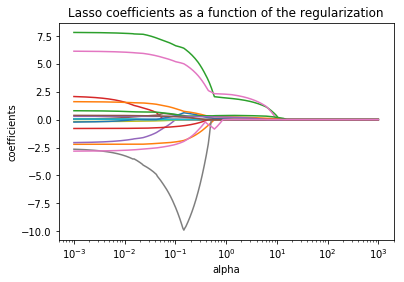

In [6]:
# The coefficients trajectories
alphas_l = np.logspace(-3, 3, 300)
#print(alphas_l)

# Normalize the predictors
clf_l = linear_model.Lasso(normalize = True, max_iter = 1e4)
coefs_l = []
for a in alphas_l:
    clf_l.set_params(alpha = a)
    clf_l.fit(X, y)
    coefs_l.append(clf_l.coef_)
    
ax = plt.gca()
ax.plot(alphas_l, coefs_l)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.show()

As can be seen from the plot, alpha is around 10 when there are three predictors left.

In [7]:
# Find the last three predictors left
clf_lt = linear_model.Lasso(normalize = True, max_iter = 1e5, alpha = 10)
clf_lt.fit(X, y)
for col, coef in zip(hitters_n, clf_lt.coef_):
    print(col+':', coef)

index: 0.0
AtBat: 0.0
Hits: 0.32947458556868225
HmRun: 0.0
Runs: 0.0
RBI: 0.0
Walks: 0.0
Years: 0.0
CAtBat: 0.0
CHits: 0.0
CHmRun: 0.0
CRuns: 0.07632196852894138
CRBI: 0.20447491636853826
CWalks: 0.0
PutOuts: 0.0
Assists: 0.0
Errors: 0.0


The final three predictors that remain in the model are "Hits", "CRuns" and "CRBI".

#### Select the optimal regularization penalty using 10-fold cross validation

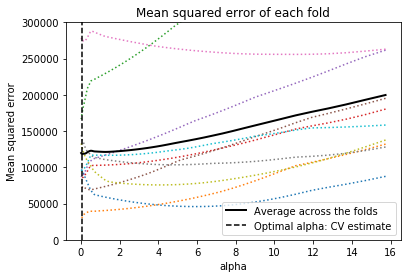

The optimal regularization penalty: 0.06814


In [8]:
model = LassoCV(cv=10, normalize = True).fit(X, y.values.ravel())

ymin, ymax = 0, 300000
plt.plot(model.alphas_, model.mse_path_, ':')
plt.plot(model.alphas_, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='Optimal alpha: CV estimate')

plt.legend()

plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error of each fold')
plt.ylim(ymin, ymax)
plt.show()
print("The optimal regularization penalty:", round(model.alpha_,5))

In [9]:
# Find the predictors left
print("The coefficients of optimal regularization penalty:")
for col, coef_l in zip(hitters_n.columns, model.coef_):
        print(col, coef_l)

The coefficients of optimal regularization penalty:
index 0.03758292182228577
AtBat -2.078653455801867
Hits 6.979030133983164
HmRun 0.0
Runs -0.5788086167405471
RBI 0.5265095017394689
Walks 5.4649306675376375
Years -6.300131275916863
CAtBat -0.08166159011472328
CHits 0.0
CHmRun 0.18579261828357965
CRuns 1.1967689200511102
CRBI 0.568413554276632
CWalks -0.6827291618827958
PutOuts 0.2915503581208234
Assists 0.2985686164081585
Errors -2.3934772643736855


14 predictors are left.

In [10]:
# Prediction
SalaryPred_l = model.predict(X)
SalaryPred_l = pd.DataFrame(SalaryPred_l)
SalaryPred_l.rename(columns = {0:'SalaryPrediction'}, inplace = True)
hitters_pred_l = pd.concat([hitters_n, SalaryPred_l], axis=1)
hitters_pred_l[['Salary', 'SalaryPrediction']].head()

,Salary,SalaryPrediction
0,475.0,413.649770
1,480.0,778.402179
2,500.0,1055.930163
3,91.5,463.231182
4,750.0,604.922486


#### 1.2 Repeat with Ridge Regression. Visualize coeffecient trajectories. Use cross-validation to find the optimal vaule of the regularization penalty.

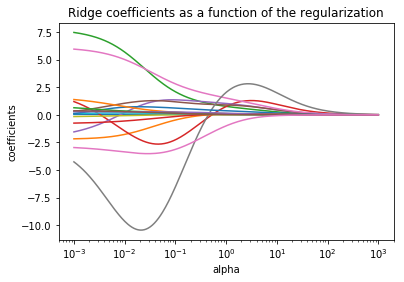

In [11]:
# The coefficient trajectory
clf_r = Ridge(normalize = True)
coefs_r = []
alphas_r = np.logspace(-3, 3, 300)

# Train the model with different regularization penalties
for a in alphas_r:
    clf_r.set_params(alpha = a)
    clf_r.fit(X, y)
    coefs_r.append(clf_r.coef_[0])

# Display results
ax = plt.gca()
ax.plot(alphas_r, coefs_r)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [12]:
# Do cross validation for Ridge
model_r = RidgeCV(alphas = alphas_r, normalize = True, cv = 10)
model_r.fit(X, y.values.ravel())
print("The optimal regularization penalty:", model_r.alpha_)

The optimal regularization penalty: 1.17553107387837


In [13]:
# Find out which predictors are in the model with the optimal regularization penalty
for col, coef_or in zip(hitters_n.columns, model_r.coef_):
    print(col, coef_or)

index 0.03288992662142732
AtBat 0.10093606424475011
Hits 0.728391163579096
HmRun 0.9008882901453134
Runs 1.0043716265259401
RBI 0.8894778142851264
Walks 1.4602525128088815
Years 2.2842523472287777
CAtBat 0.011145417957545162
CHits 0.050633394863072695
CHmRun 0.3584015802108384
CRuns 0.10191629026317106
CRBI 0.10554429786601806
CWalks 0.07021973210804774
PutOuts 0.13794627555151098
Assists 0.021166983944793095
Errors -0.8694127011328567


Using Ridge regression and the optimal regularization, the model still contains all the predictors. This is because Ridge regression does not reduce the coefficients to zero.

In [14]:
# Predict salary using the Ridge with the optimal regularization
SalaryPred_r = model_r.predict(X)
SalaryPred_r = pd.DataFrame(SalaryPred_r)
SalaryPred_r.rename(columns = {0:'SalaryPred'}, inplace = True)
hitters_pred_r = pd.concat([hitters_n, SalaryPred_r], axis=1)
hitters_pred_r[['Salary', 'SalaryPred']].head()

,Salary,SalaryPred
0,475.0,538.659935
1,480.0,658.732970
2,500.0,837.823953
3,91.5,371.225739
4,750.0,629.375007


#### 2. Short Answer. Explain in your own words the bias-variance tradeoff. What role does regularization play in this tradeoff? Make reference to your findings in number (1) to describe models of high/low bias and variance.

The bias-variance tradeoff is the dilemma that the predictive models cannot have a lower bias and a lower variance at the same time.
Models with more predictors will have higher variances than models with fewer predictors. But models with fewer predictors will have a higher bias.

Regularization reduces the variance of the model by limiting the variation of the coefficients. And regularization also reduces the chance of overfitting.

In Question 1, the Lasso regression model with the optimal regularization have only 14 predictors while the Ridge regression has all 16 predictors. The Lasso model has a lower variance and a higher bias, whereas the Ridge regression has a higher variance and a lower bias.